# Delayed processing with Dask

In this notebook we will work with a dataset that exceeds the amount of available memory. The trick is to use [Dask delayed processing](https://docs.dask.org/en/stable/delayed.html) capabilities.

In [1]:
import numpy as np
import dask
import dask.array as da
from dask import delayed
import matplotlib.pyplot as plt
import stackview
from timeit import timeit

# see mandelbrot.py
from mandelbrot import mandelbrot_array

As example, we use the [mandelbrot set](https://en.wikipedia.org/wiki/Mandelbrot_set) that can be visualized as images with various zoom levels.

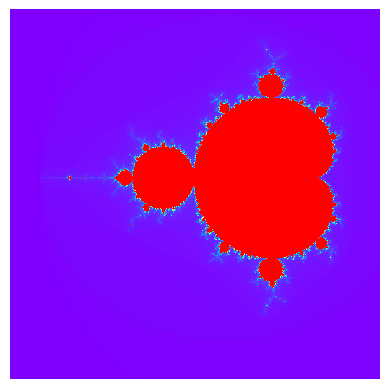

In [2]:
stackview.imshow(mandelbrot_array(scale=3))

[[ 26  26  26 ... 256 256 256]
 [ 26  26  26 ... 256 256 256]
 [ 26  26  26 ... 256 256 256]
 ...
 [ 25  25  25 ... 256 256 256]
 [ 25  25  25 ... 256 256 256]
 [ 25  25  25 ... 256 256 256]]
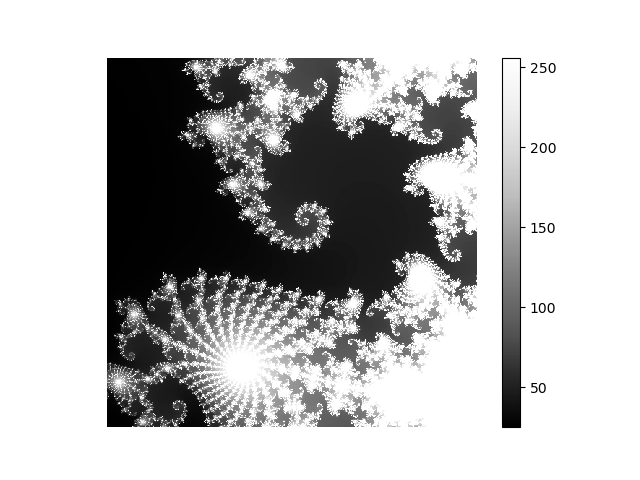
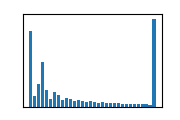

In [3]:
stackview.insight(mandelbrot_array(scale=0.01))

## Compute time considerations

First, we use [timeit](https://docs.python.org/3/library/timeit.html) to measure how long the computation of one image takes.

In [4]:
%%timeit
mandelbrot_array()

230 ms ± 4.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


If computing a single image takes 0.3 seconds, and we need to compute 200000 images, this will take a while.

In [5]:
single_image_time = 0.3 
number_of_images = 200000

single_image_time * number_of_images / 60 / 60, "h"

(16.666666666666668, 'h')

Hence, if we wanted to generate a stack of images where we can zoom in, this might take hours.

## Delayed processing
A way to deal with long compute times is _delayed_ processing. Goal of this technique is to have a dataset ready for manual inspection, e.g. viewing individual slice of the data, and handle it as a normmal array or [Dask stack](https://docs.dask.org/en/latest/array-stack.html).

The first step is to _delay_ a function, by decorating it with `@delayed`. 

In [6]:
@delayed
def render_level(i):
    from mandelbrot import SCALE0, ZOOM_PER_LEVEL
    scale = SCALE0 / (ZOOM_PER_LEVEL ** i)
    return mandelbrot_array(scale=scale)

Next, we create a list of delayed objects and turn this list into a stack. A stack is n+1 dimensional arrays with dimensionality n.

In [7]:
from mandelbrot import WIDTH, HEIGHT, SCALE0
DTYPE = np.uint16
CHUNKS = (1, 256, 256)

levels = [
    da.from_delayed(
        render_level(i),
        shape=(HEIGHT, WIDTH), dtype=DTYPE
    )
    for i in range(number_of_images)
]
stack = da.stack(levels, axis=0).rechunk(CHUNKS)

In Jupyter notebooks, such a `stack` renders a preview specifying how the data looks like. Note that until here, no Mandelbrot images was computed yet.

In [8]:
stack

dask.array<rechunk-merge, shape=(200000, 512, 512), dtype=uint16, chunksize=(1, 256, 256), chunktype=numpy.ndarray>

We can also show individual slices in the stack.

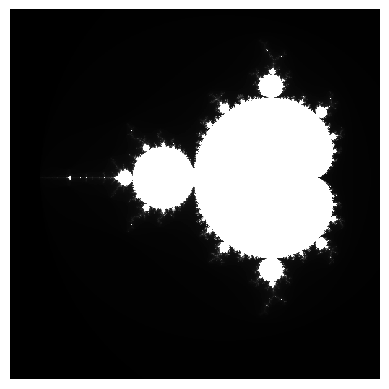

In [9]:
stackview.imshow(stack[0])

In [10]:
type(stack[0])

dask.array.core.Array

We can also generate animations from the images in this huge stack. In the following, we compute 20 slices, which take some time.

In [11]:
image = np.asarray(stack[0:20000:1000,::2,::2])
image.shape

(20, 256, 256)

C:\Users\rober\miniforge3\envs\bob-env\Lib\site-packages\stackview\_animate.py:43: UserWarning: The timelapse has an intensity range exceeding 0..255. Consider normalizing it to the range between 0 and 255.
  warnings.warn("The timelapse has an intensity range exceeding 0..255. Consider normalizing it to the range between 0 and 255.")



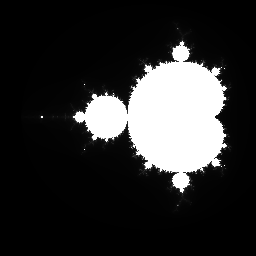

In [12]:
stackview.animate(image)

## Exercise
Find the first image in the stack where all pixels values have the same intensity.

In [13]:
stack.shape

(200000, 512, 512)

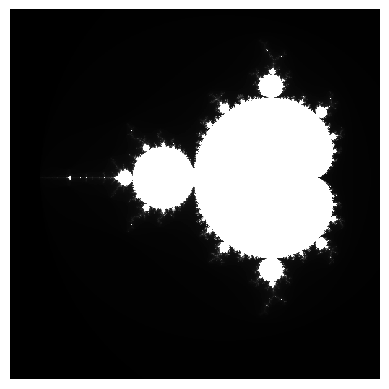

In [14]:
stackview.imshow(stack[0])

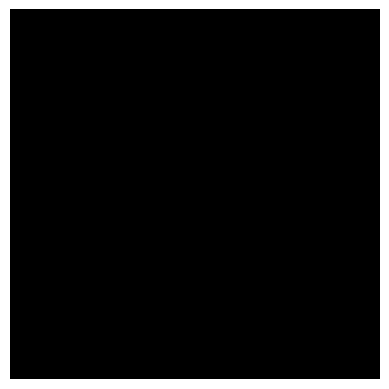

In [15]:
stackview.imshow(stack[-1])